## Importing libraries

In [ ]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## Setting GPU growth

In [ ]:
# Avoid Out of memory errors by setting Memory Consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures

In [ ]:
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')
anc_path = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

## Preparing dataset

Uncompressing Tar GZ Labelled faces in the Wild Dataset

In [ ]:
!tar -xf lfw.tgz

Move LFW Images to data/negative repository

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(neg_path, file)
        os.replace(EX_PATH, NEW_PATH)

Collecting Postive and Anchor Classes

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
uuid.uuid1()

UUID('3a966f00-72aa-11ec-b6a3-0242ac1c0002')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  frame = frame[120:120+250, 200:200+250, :]

  # Collect anchors 
  if cv2.waitKey(1) & 0xFF == ord('a'):
    # Create the unique file path 
    imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)

  # Collect positives
  if cv2.waitKey(1) & 0xFF == ord('p'):
    # Create the unique file path 
    imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
    # Write out anchor image
    cv2.imwrite(imgname, frame)

  # Show image back to screen
  cv2.imshow('Image Collection', frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

Getting Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(485)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(485)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(485)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test.next()

b'data/anchor/0da8c1a8-7220-11ec-86e3-fa455f00e835.jpg'

## Preprocessing scale and resize

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
preprocess('data/anchor/22267d96-7220-11ec-86e3-fa455f00e835.jpg')

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.6843137 , 0.70438844, 0.7061158 ],
        [0.6861345 , 0.7018208 , 0.70574236],
        [0.68552756, 0.6929505 , 0.6996265 ],
        ...,
        [0.69411767, 0.6666667 , 0.627451  ],
        [0.7005602 , 0.67310923, 0.63389355],
        [0.69145656, 0.6640056 , 0.6247899 ]],

       [[0.6821195 , 0.7056489 , 0.7056489 ],
        [0.6862745 , 0.7019608 , 0.7058824 ],
        [0.689029  , 0.7023343 , 0.7070495 ],
        ...,
        [0.6976191 , 0.6701681 , 0.6309524 ],
        [0.68347335, 0.65602237, 0.6168067 ],
        [0.7014939 , 0.67404294, 0.63482726]],

       [[0.6784314 , 0.7019608 , 0.7019608 ],
        [0.682493  , 0.7021008 , 0.70406157],
        [0.6862745 , 0.7019608 , 0.7058824 ],
        ...,
        [0.69211024, 0.66465926, 0.6254436 ],
        [0.69523805, 0.6677871 , 0.6285714 ],
        [0.6793651 , 0.6519141 , 0.61269844]],

       ...,

       [[0.32619047, 0.35410833, 0.39309058],
        [0.27

In [ ]:
img = preprocess('data/anchor/22267d96-7220-11ec-86e3-fa455f00e835.jpg')

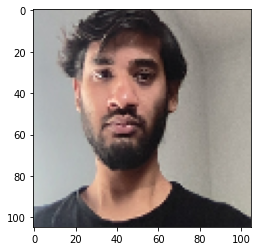

In [ ]:
plt.imshow(img)

## Creating Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# (anchor, negative) => 0,0,0,0,0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#Combining postive and negative samples into one data
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()
samples.next()

(b'data/anchor/1216096c-7220-11ec-86e3-fa455f00e835.jpg',
 b'data/positive/d9e6e6bc-721d-11ec-8476-fa455f00e835.jpg',
 1.0)

In [ ]:
example = samples.next()

## Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.7058824 , 0.7411765 , 0.7372549 ],
         [0.70840335, 0.7280112 , 0.7397759 ],
         [0.70662934, 0.73099905, 0.7439309 ],
         ...,
         [0.687955  , 0.6761903 , 0.64873934],
         [0.67927176, 0.66750705, 0.6400561 ],
         [0.6690943 , 0.6573296 , 0.62987864]],
 
        [[0.7054155 , 0.7407096 , 0.73678803],
         [0.7162465 , 0.7358543 , 0.74761903],
         [0.707423  , 0.7294118 , 0.74038285],
         ...,
         [0.6838936 , 0.6721289 , 0.64467794],
         [0.6701681 , 0.6584034 , 0.6309524 ],
         [0.6802521 , 0.66848737, 0.6410364 ]],
 
        [[0.70368814, 0.73702145, 0.73898226],
         [0.7123249 , 0.73193276, 0.74369746],
         [0.7125583 , 0.7321662 , 0.7439309 ],
         ...,
         [0.69173676, 0.67997205, 0.6525211 ],
         [0.68137246, 0.66960776, 0.6421568 ],
         [0.6580299 , 0.6462652 , 0.61881423]],
 
        ...,
 
        [[0.81419235, 0.8494865 

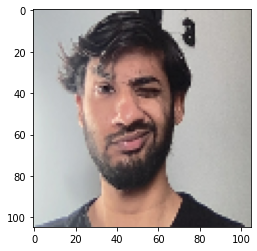

In [ ]:
plt.imshow(res[0])

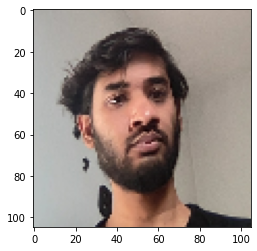

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

Build Embedding Layer

In [ ]:
def make_embedding(): 
    input = Input(shape=(105,105,3), name='input_image')
    
    # First block
    conv1 = Conv2D(64, (10,10), activation='relu')(input)
    maxpool1 = MaxPooling2D(64, (2,2), padding='same')(conv1)
    
    # Second block
    conv2 = Conv2D(128, (7,7), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(64, (2,2), padding='same')(conv2)
    
    # Third block 
    conv3 = Conv2D(128, (4,4), activation='relu')(maxpool2)
    maxpool3 = MaxPooling2D(64, (2,2), padding='same')(conv3)
    
    # Final embedding block
    conv4 = Conv2D(256, (4,4), activation='relu')(maxpool3)
    flatten1 = Flatten()(conv4)
    dense1 = Dense(4096, activation='sigmoid')(flatten1)
    
    
    return Model(inputs=[input], outputs=[dense1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

Build Distance Layer

In [ ]:
# Siamese L1 Distance class
class L1Distance(Layer):

  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

Build Siamese Model

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network = make_siamese_model()

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Training Model

Setting up loss function

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

Setting up Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Establishing Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_network=siamese_network)

Build Train Step Function

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_network(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_network.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_network.trainable_variables))
    
    # Return loss
    return loss

Build Training Loop

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        print('\n Loss {}'.format(train_step(batch)))
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 200

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/200
43/43 [==============================] - 32s 766ms/step

 Loss 3.1846172987570753e-06

 Epoch 2/200
43/43 [==============================] - 32s 761ms/step

 Loss 4.76837954010989e-07

 Epoch 3/200
43/43 [==============================] - 32s 762ms/step

 Loss 1.359023190161679e-05

 Epoch 4/200
43/43 [==============================] - 32s 761ms/step

 Loss 5.7916953664971516e-05

 Epoch 5/200
43/43 [==============================] - 32s 762ms/step

 Loss 9.621904837331385e-07

 Epoch 6/200
43/43 [==============================] - 32s 761ms/step

 Loss 8.038337909965776e-06

 Epoch 7/200
43/43 [==============================] - 32s 762ms/step

 Loss 1.3623925099182088e-07

 Epoch 8/200
43/43 [==============================] - 32s 762ms/step

 Loss 6.317107181530446e-05

 Epoch 9/200
43/43 [==============================] - 32s 761ms/step

 Loss 3.834790550172329e-05

 Epoch 10/200
43/43 [==============================] - 32s 761ms/step

 Loss 1.70302973856451e-05

 Epoch 

## Evaluate Model

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Getting a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# Making predictions
y_hat = siamese_network.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [9.9999976e-01],
       [1.0000000e+00],
       [2.6049012e-09],
       [8.9501140e-10],
       [2.1281235e-09],
       [1.0785016e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2583014e-08],
       [2.9183832e-11],
       [1.1185365e-06],
       [5.6269891e-09],
       [9.9999893e-01],
       [1.0000000e+00],
       [1.0351748e-12]], dtype=float32)

In [ ]:
# Post processing the results
[1 if predications > 0.5 else 0 for predications in y_hat]

[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

# Visualizing the results

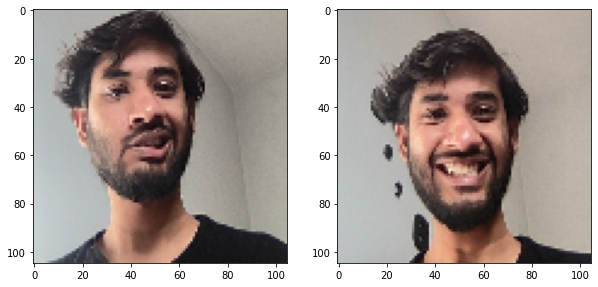

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

## Save Model

In [ ]:
# Save weights
siamese_network.save('siamesemodel.h5')

In [ ]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy()})

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Real Time Test

In [124]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [126]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
